In [80]:
import pandas as pd
import matplotlib.pyplot as plt
from cycler import cycler
import numpy as np
import re

In [81]:
plt.rcParams["figure.figsize"] = (10,6)

In [82]:
df = pd.read_csv('../results/circuit_results_05-10-2023_21_37_33.csv')

In [83]:
df.head()

,circuit,protocol,iters,train_size,test_size,pval,data_time,d_tree_time,bias_sharing,bias_and,accidental_secret,accidental_gate
0,adder_1.txt,gmw,64,128,64,1.0,0.16,1.55,0,0,0.0,0.0
1,adder_1.txt,gmw,64,128,64,1.0,0.23,1.62,0,0,0.0,0.0
2,adder_1.txt,gmw,64,128,64,1.0,0.28,1.81,0,0,0.0,0.0
3,adder_1.txt,gmw,64,256,128,1.0,0.35,1.84,0,0,0.0,0.0
4,adder_1.txt,gmw,64,256,128,1.0,0.28,1.81,0,0,0.0,0.0


# Fixing Test Power, Graphing P-Values

In [97]:
iters = 64
train_size = 128
test_size = 64
protocol = 'gmw'

def make_graph(iters=128, train_size=512, test_size=256, protocol='gmw'):
    adders = {n: f'adder_{n}.txt' for n in range(1, 33)}
    adders_set = set(list(adders.values()))
    replace = {v: k for k, v in adders.items()}

    df_graph = df[(df['iters'] == iters) & (df['train_size'] == train_size) & (df['test_size'] == test_size) & 
                  (df['protocol'] == protocol) & (df['circuit'].isin(adders_set))]
    df_graph['circuit_num'] = df_graph['circuit'].apply(lambda x: replace[x])

    df_g = df_graph.groupby('circuit_num')

    means = df_g.mean()['pval']
    stds = df_g.std()['pval']

    def get_broken(df, b1, b2, b3, b4):
        return df[(df['bias_sharing'] == b1) & (df['bias_and'] == b2) & 
                  (df['accidental_secret'] == b3) & (df['accidental_gate'] == b4)]

    results = {'Secure': get_broken(df_graph, 0, 0, 0, 0),
               'Biased Sharing (1)': get_broken(df_graph, 1, 0, 0, 0),
               'Biased Sharing (2)': get_broken(df_graph, 2, 0, 0, 0),
               'Biased AND (1)': get_broken(df_graph, 0, 1, 0, 0),
               'Biased AND (2)': get_broken(df_graph, 0, 2, 0, 0),
               'Accidental Secret Send (1/4)': get_broken(df_graph, 0, 0, 1/4, 0),
               'Accidental Gate Send (1/4)': get_broken(df_graph, 0, 0, 0, 1/4),
               'Accidental Secret Send (1/2)': get_broken(df_graph, 0, 0, 1/2, 0),
               'Accidental Gate Send (1/2)': get_broken(df_graph, 0, 0, 0, 1/2),
              }

    ls_cycler = cycler('linestyle',
                        [(0,()), # solid 
                         (0, (1, 10)), # loosely dotted
                         (0, (1, 5)), # dotted
                         (0, (1, 1)), # densely dotted
                         (0, (5, 10)), # loosely dashed
                         (0, (5, 5)), # dashed
                         (0, (5, 1)), # densely dashed
                         (0, (3, 10, 1, 10)), # loosely dashdotted
                         (0, (3, 5, 1, 5)), # dashdotted
                         (0, (3, 1, 1, 1)), # densely dashdotted
                         (0, (3, 10, 1, 10, 1, 10)), # loosely dashdotdotted
                         (0, (3, 5, 1, 5, 1, 5)), # dashdotdotted
                         (0, (3, 1, 1, 1, 1, 1))] # densely dashdotdotted
                      )

    ls_cycler = cycler('linestyle',
                       ['-','-','--',':','-.',(0, (5, 1)),(0, (3, 1, 1, 1, 1, 1)), (0, (3, 5, 1, 5)), (0, (3, 1, 1, 1, 1, 1))])
    color_cycler = cycler('color', 'rgbmykcrg') #bgrcmyk | 
    marker ='.'
    marker_cycler = cycler('marker', ['', 'x','*', '>', 'p', 's','.','>', '.']) #, '.'])
    # cycler('color', [plt.get_cmap('jet')(i/13) for i in range(13)] )

    new_cycler = color_cycler + ls_cycler + marker_cycler

    plt.rcParams['axes.prop_cycle'] = new_cycler
    for k, v in results.items():
        df_g = v.groupby('circuit_num')
        means = df_g.mean()['pval']
        #print(means)
        stds = df_g.std()['pval']

        x = means.index
        y = means
        error = stds
        plt.plot(x, y,label=k)
        plt.fill_between(x, y-error, y+error, alpha=.25, linewidth=0)

    plt.legend()
    plt.show()

# 64 Iters, GMW

/tmp/ipykernel_1454631/585248754.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_graph['circuit_num'] = df_graph['circuit'].apply(lambda x: replace[x])


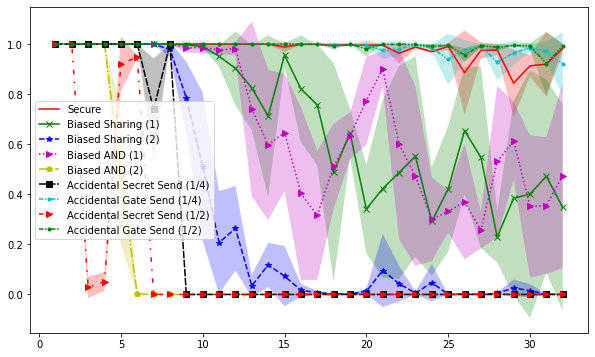

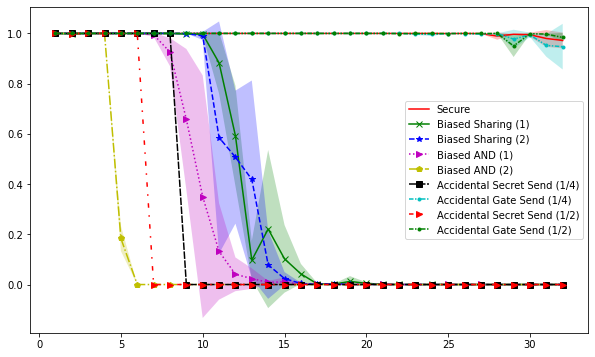

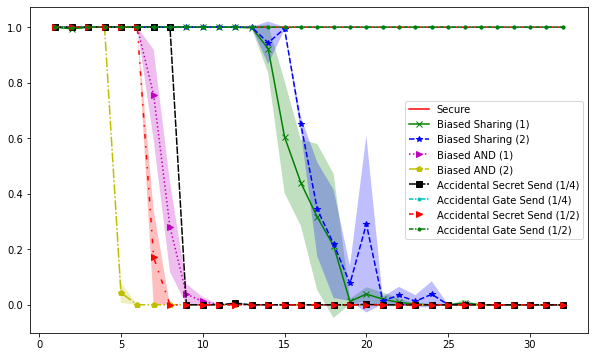

In [98]:
iters=64
protocol='gmw'
for train_size in [128, 256, 512]:
    test_size=train_size/2
    make_graph(iters, train_size, test_size, protocol)

# 128 Iters, GMW

/tmp/ipykernel_1454631/585248754.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_graph['circuit_num'] = df_graph['circuit'].apply(lambda x: replace[x])


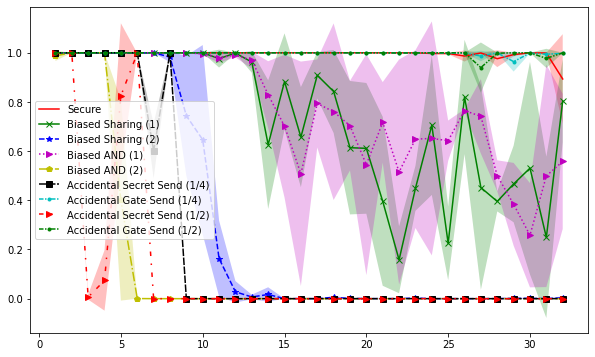

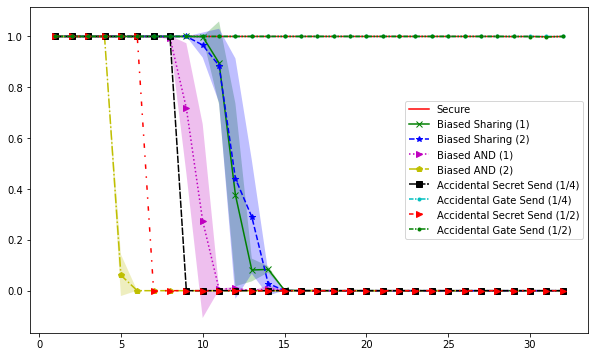

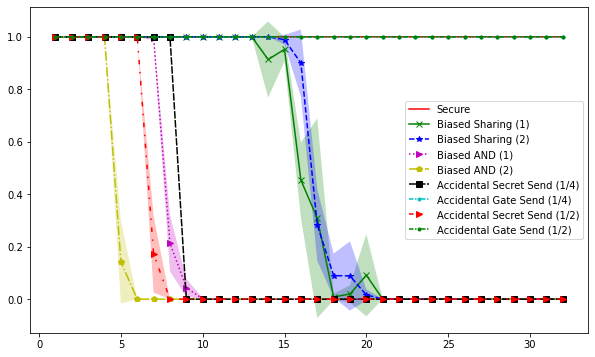

In [99]:
iters=128
protocol='gmw'
for train_size in [128, 256, 512]:
    test_size=train_size/2
    make_graph(iters, train_size, test_size, protocol)

# 64 iters, Beaver

/tmp/ipykernel_1454631/585248754.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_graph['circuit_num'] = df_graph['circuit'].apply(lambda x: replace[x])


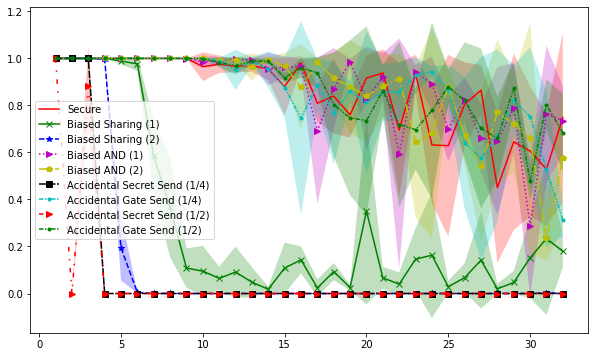

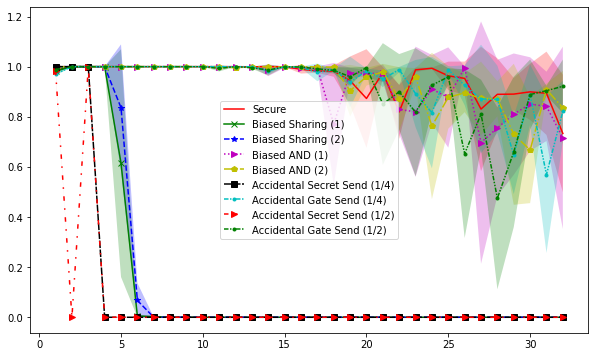

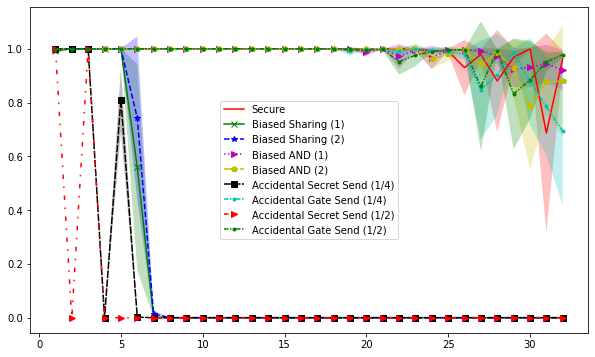

In [100]:
iters=64
protocol='beaver'
for train_size in [128, 256, 512]:
    test_size=train_size/2
    make_graph(iters, train_size, test_size, protocol)

# 128 iters, Beaver

/tmp/ipykernel_1454631/585248754.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_graph['circuit_num'] = df_graph['circuit'].apply(lambda x: replace[x])


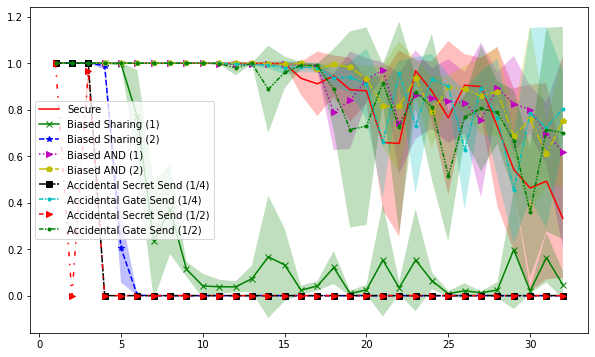

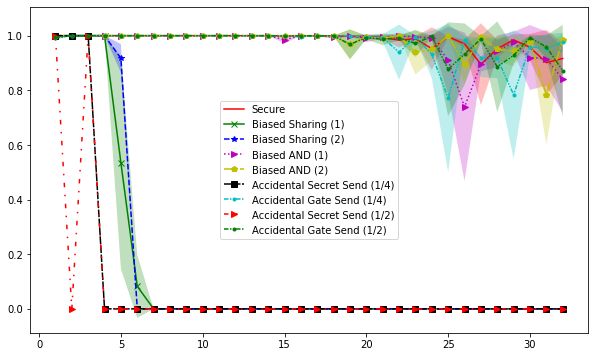

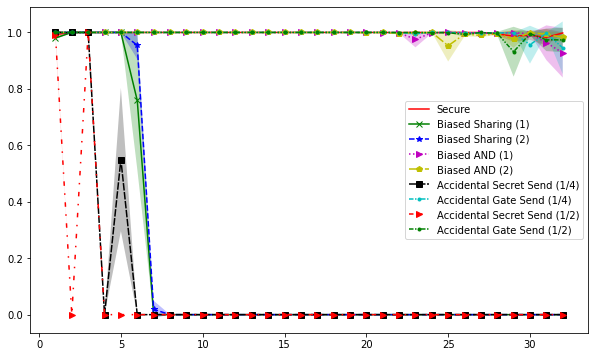

In [101]:
iters=128
protocol='beaver'
for train_size in [128, 256, 512]:
    test_size=train_size/2
    make_graph(iters, train_size, test_size, protocol)

# Analysis Time

In [102]:
def make_time_graph(time_col):
    adders = {n: f'adder_{n}.txt' for n in range(1, 33)}
    adders_set = set(list(adders.values()))
    replace = {v: k for k, v in adders.items()}

    df_graph = df[(df['circuit'].isin(adders_set))]
    df_graph['circuit_num'] = df_graph['circuit'].apply(lambda x: replace[x])

    def get_df(df, iters, train_size, protocol):
        test_size = train_size / 2
        return df[(df['iters'] == iters) & (df['train_size'] == train_size) & (df['test_size'] == test_size) & 
                  (df['protocol'] == protocol) & 
                  (df['bias_sharing'] == 0) & (df['bias_and'] == 0) & 
                  (df['accidental_secret'] == 0) & (df['accidental_gate'] == 0)]

    results = {
        'Iters = 64, Training Size = 128, GMW': get_df(df_graph, 64, 128, 'gmw'),
        'Iters = 64, Training Size = 256, GMW': get_df(df_graph, 64, 256, 'gmw'),
        'Iters = 64, Training Size = 512, GMW': get_df(df_graph, 64, 512, 'gmw'),
        'Iters = 128, Training Size = 128, GMW': get_df(df_graph, 128, 128, 'gmw'),
        'Iters = 128, Training Size = 256, GMW': get_df(df_graph, 128, 256, 'gmw'),
        'Iters = 128, Training Size = 512, GMW': get_df(df_graph, 128, 512, 'gmw'),
        'Iters = 64, Training Size = 128, Beaver': get_df(df_graph, 64, 128, 'beaver'),
        'Iters = 64, Training Size = 256, Beaver': get_df(df_graph, 64, 256, 'beaver'),
        'Iters = 64, Training Size = 512, Beaver': get_df(df_graph, 64, 512, 'beaver'),
        'Iters = 128, Training Size = 128, Beaver': get_df(df_graph, 128, 128, 'beaver'),
        'Iters = 128, Training Size = 256, Beaver': get_df(df_graph, 128, 256, 'beaver'),
        'Iters = 128, Training Size = 512, Beaver': get_df(df_graph, 128, 512, 'beaver'),
              }

    ls_cycler = cycler('linestyle',
                        [(0,()), # solid 
                         (0, (1, 10)), # loosely dotted
                         (0, (1, 5)), # dotted
                         (0, (1, 1)), # densely dotted
                         (0, (5, 10)), # loosely dashed
                         (0, (5, 5)), # dashed
                         (0, (5, 1)), # densely dashed
                         (0, (3, 10, 1, 10)), # loosely dashdotted
                         (0, (3, 5, 1, 5)), # dashdotted
                         (0, (3, 1, 1, 1)), # densely dashdotted
                         (0, (3, 10, 1, 10, 1, 10)), # loosely dashdotdotted
                         (0, (3, 5, 1, 5, 1, 5)), # dashdotdotted
                         (0, (3, 1, 1, 1, 1, 1))] # densely dashdotdotted
                      )

    ls_cycler = cycler('linestyle',
                       ['-','--',':','-.',(0, (5, 1)),(0, (3, 1, 1, 1, 1, 1)), (0, (3, 5, 1, 5)), (0, (3, 1, 1, 1, 1, 1))])
    color_cycler = cycler('color', 'rgbmykcr') #bgrcmyk | 
    marker ='.'
    marker_cycler = cycler('marker', ['', 'x','*', '>', 'p', 's','.','>']) #, '.'])
    # cycler('color', [plt.get_cmap('jet')(i/13) for i in range(13)] )

    new_cycler = color_cycler + ls_cycler + marker_cycler

    plt.rcParams['axes.prop_cycle'] = new_cycler
    for k, v in results.items():
        df_g = v.groupby('circuit_num')
        means = df_g.mean()[time_col]
        #print(means)
        stds = df_g.std()[time_col]

        x = means.index
        y = means
        error = stds
        plt.plot(x, y,label=k)
        plt.fill_between(x, y-error, y+error, alpha=.25, linewidth=0)

    plt.legend()
    plt.show()

/tmp/ipykernel_1454631/4095821801.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_graph['circuit_num'] = df_graph['circuit'].apply(lambda x: replace[x])


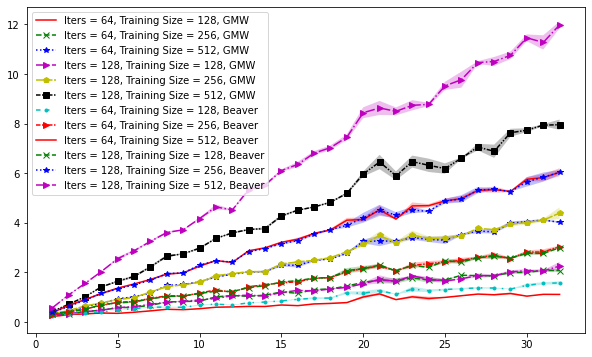

In [103]:
make_time_graph('data_time')

/tmp/ipykernel_1454631/4095821801.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_graph['circuit_num'] = df_graph['circuit'].apply(lambda x: replace[x])


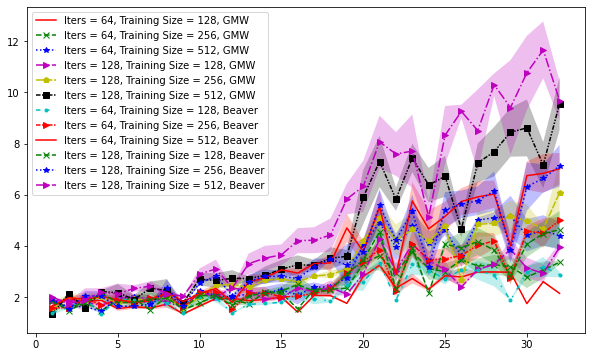

In [104]:
make_time_graph('d_tree_time')